## Script for automated analysis of trajectories from flies in fly bowl during CsChrimson stimulation
###Project: Flp-out based CsChrimson activation of putative CX-output neurons in walking flies

In [3]:
from scipy.io import loadmat
import csv
import numpy as np
from scipy import sparse as sps

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import matplotlib.colors as colors

import os
from glob import glob
from os.path import isfile, sep

import seaborn as sns

from flyBowlChrAssay_plottingFunctions import plotSparseMatrix, plotPosInRange, plotVeloHistogram,
    veloPerTrial, veloPerTrialAverage, plotPosAndAngleInRange_singleFly_colorStim,
    plotPosAndAngleInRange_singleFly_colorTrial, plotPosAndAngleInRange_singleFly_separateTrials

%matplotlib inline

# Note: Additional functions are defined at the end of this script. 
# Corresponding cells need to be evaluated before running the ananlysis for the first time

In [85]:
rootDir = '/Volumes/jayaraman/Chuntao/Ming_FlyBowl/'#'/Users/hannah/Desktop/flyBowlTestData/SS02232/'
analysisDir = '/Volumes/jayaraman/Hannah/Analysis_Ming_FlyBowl/'# rootDir +'analysis' + sep
fps = 30 # Video sampling rate

dateDirs = os.walk(rootDir).next()[1]

dateDir = dateDirs[0]
expList =  os.walk(rootDir+dateDir).next()[1] # + 'rawData' + sep

expList

['OL0020B_A_flyBowlMing_protocol_Chuntao_30intensity_1s_20151104T150621',
 'OL0020B_A_flyBowlMing_protocol_Chuntao_15intensity_1s_20151104T150127',
 'SS02386_A_flyBowlMing_protocol_Chuntao_15intensity_1s_20151104T152757',
 'SS02619_A_flyBowlMing_protocol_Chuntao_30intensity_1s_20151104T152001',
 'OL0020B_A_flyBowlMing_protocol_Chuntao_15intensity_1s_20151104T155619',
 'SS02386_A_flyBowlMing_protocol_Chuntao_30intensity_1s_20151104T154630',
 'SS02386_A_flyBowlMing_protocol_Chuntao_30intensity_1s_20151104T153225',
 'SS02619_A_flyBowlMing_protocol_Chuntao_15intensity_1s_20151104T151512',
 'OL0020B_A_flyBowlMing_protocol_Chuntao_30intensity_1s_20151104T160042',
 'SS02386_A_flyBowlMing_protocol_Chuntao_15intensity_1s_20151104T154125']


 Analysing the following log files in OL0020B_A_flyBowlMing_protocol_Chuntao_30intensity_1s_20151104T150621:

['ctrax_results.mat', 'indicatordata.mat', 'jaabadetect_info.mat', 'perframefeatures_info.mat', 'protocol.mat', 'registered_trx.mat', 'registrationdata.mat', 'scores_backup_rai.mat', 'sexclassifier.mat', 'wingtracking_results.mat']
OL0020B_A
flyBowlMing_protocol_Chuntao_30intensity_1s_20151104T150621
Genotype folder already exists
Protocol folder already exists


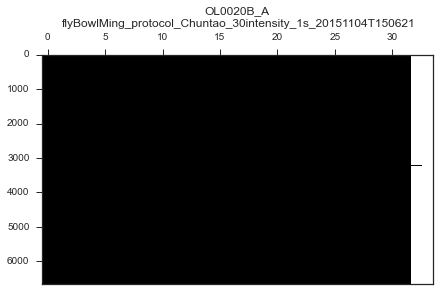

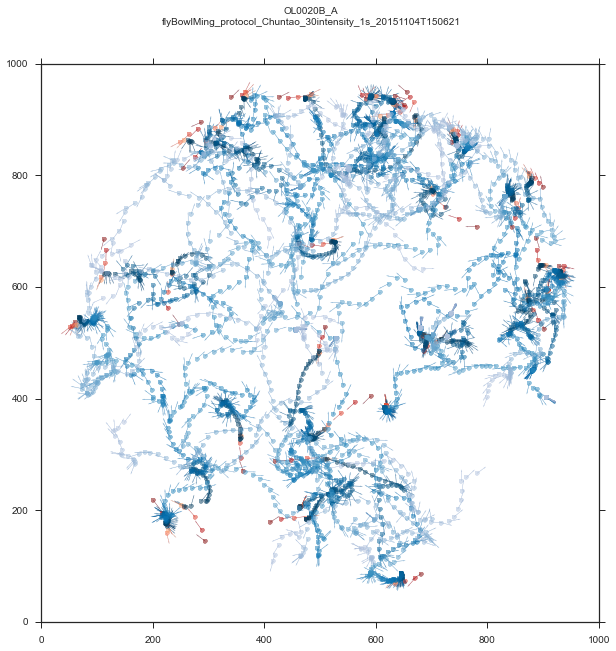

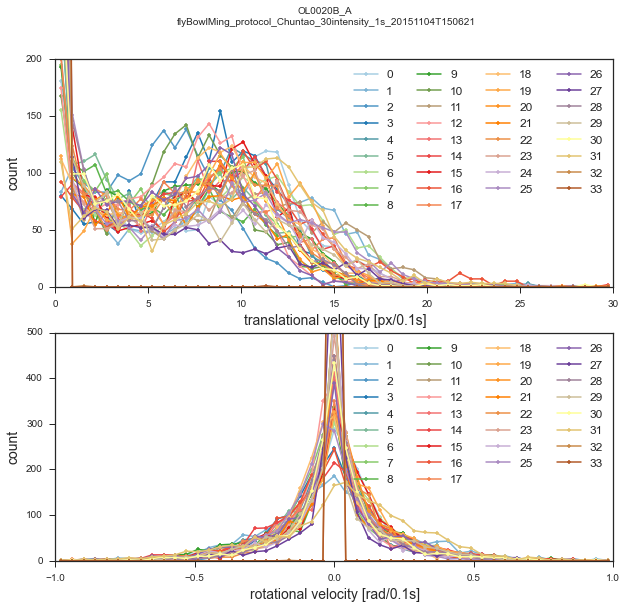

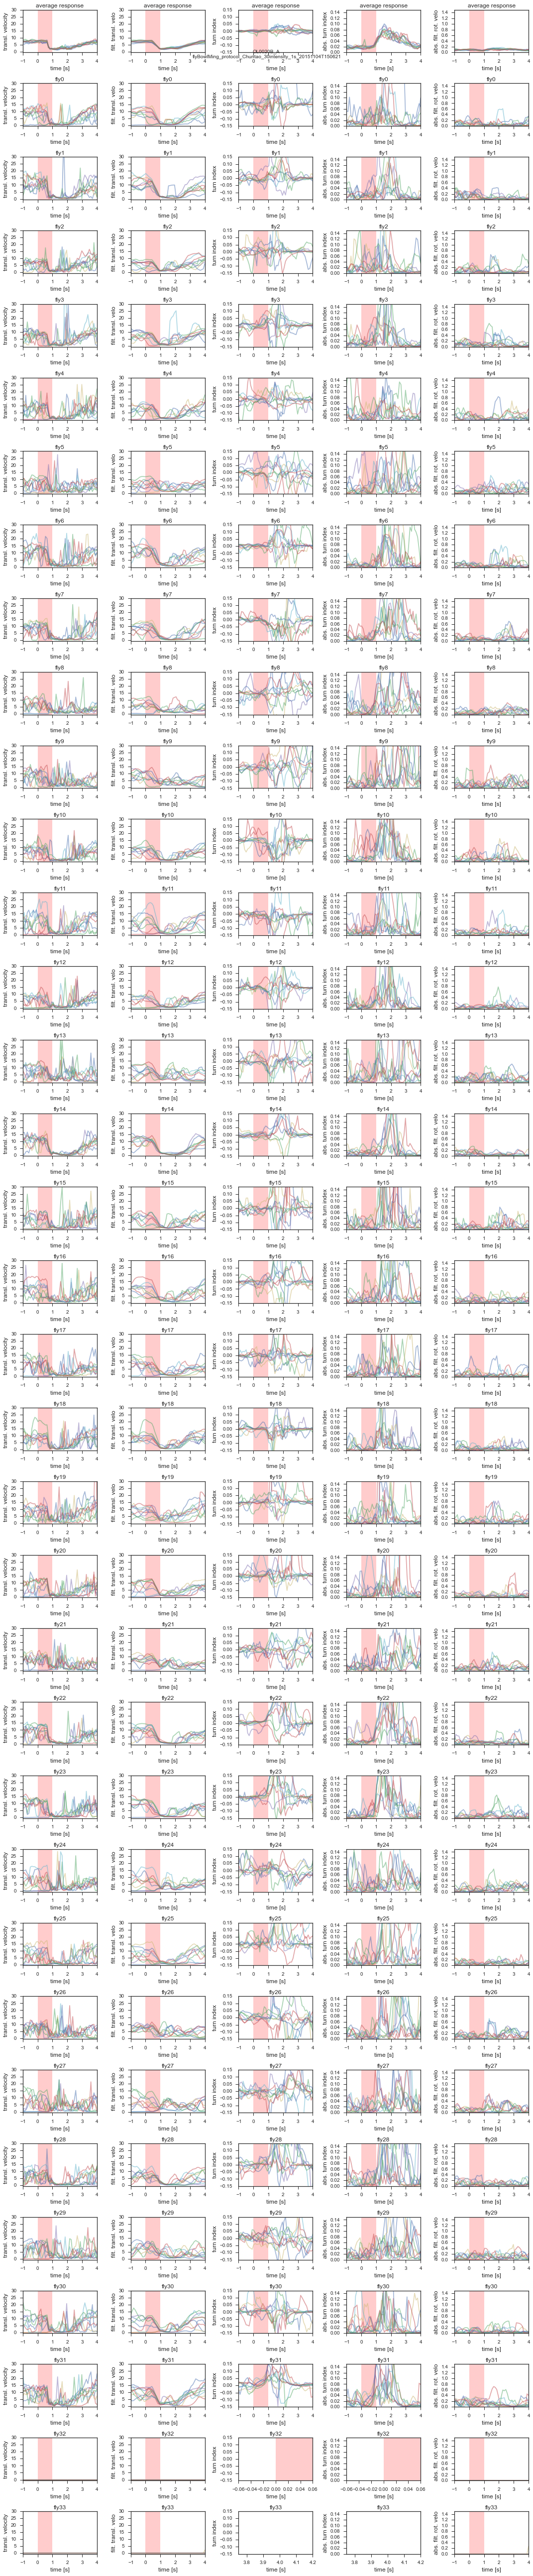

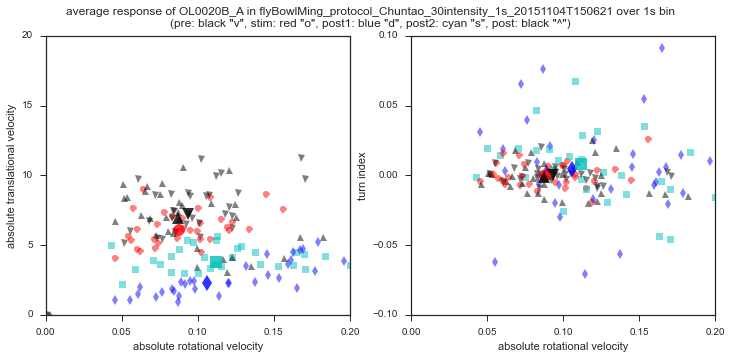

In [100]:
currDir = 0
folder = expList[currDir]
matFlyBowl = [filepath.split(sep)[-1] for filepath in glob(rootDir + dateDir + sep + folder + sep + '*.mat')]
matFlyBowl = sorted(matFlyBowl)

print('\n Analysing the following log files in '+expList[currDir]+':\n')
print(matFlyBowl)

fileNameParts = folder.split('_')

genotype = '_'.join(fileNameParts[0:fileNameParts.index('flyBowlMing')])
protocolName = '_'.join(fileNameParts[fileNameParts.index('flyBowlMing'):-1])
experiment = '_'.join(fileNameParts[fileNameParts.index('flyBowlMing'):])
timestamp = fileNameParts[-1]

print(genotype)
print(experiment)

plotSaveDir = analysisDir + genotype + sep + protocolName + sep + timestamp

try:
    os.mkdir(analysisDir + genotype )
except OSError:
    print('Genotype folder already exists')
    
try:
    os.mkdir(analysisDir + genotype + sep + protocolName)
except OSError:
    print('Protocol folder already exists')
    
try:
    os.mkdir(plotSaveDir)
except OSError:
    print('Experiment folder already exists')
    
    
# Import and rearrange data ...........................................................................................
fileName = 'ctrax_results'

# Extract relevant tracking parameter
keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle'] #data columns to be extracted from ctrax file

#load matlab data and convert
indat = loadmat(rootDir + dateDir + sep + folder + sep + fileName + '.mat')

dat = [indat[k] for k in keyList]
    
# Reorganise fly position arrays into lists (sorted by frame)
numFrames = len(dat[0])
xPos = []
yPos = []
angle = []
flyID = []

pointer = 0
for t in range(numFrames):
    numFlies = dat[3][t].astype('int')[0]

    xPos.append(dat[1][pointer:pointer+numFlies])
    yPos.append(dat[2][pointer:pointer+numFlies])
    angle.append(dat[5][pointer:pointer+numFlies])
    flyID.append(dat[4][pointer:pointer+numFlies])

    pointer += numFlies
    
xPos = np.array(xPos)
yPos = np.array(yPos)
angle = np.array(angle)
flyID = np.array(flyID)
maxFlyID = max(dat[4])

# Reorganise fly track fragments into matrix (frame x fly id )
flyIDperFrame = np.zeros((numFrames,maxFlyID+1))
for frame in range(numFrames):
    for idx in np.array(flyID[frame]).squeeze().astype('int'):
        flyIDperFrame[frame][idx] = 1
        

# Extract protocol parameter ......................................................................................
protocol = loadmat(rootDir + dateDir + sep + folder + sep + 'protocol.mat') #load protocol parameter
protocol = protocol['protocol'] #extract values from dict

intensity = protocol['intensity'].squeeze().astype('int')
pulseWidth = protocol['pulseWidthSP'].squeeze().astype('int')
pulsePeriod = protocol['pulsePeriodSP'].squeeze().astype('int')
stimTms = pulseWidth
pauseTms = protocol['offTime'].squeeze().astype('int')
numRepeat = protocol['iteration'].squeeze().astype('int')
delayStart = protocol['delayTime'].squeeze().astype('int')

stimCycle = (stimTms+pauseTms)/1000

# total length of protocol
experimentT = (delayStart + numRepeat*stimCycle*fps)

skipFrame = 3 #downsample from 30Hz --> 10Hz

#Build indicator vector for red light stimulation
stimBlock = np.hstack((np.ones((stimTms/1000)*fps),np.zeros((pauseTms/1000) * fps)))
stimCode = np.tile(stimBlock,numRepeat)

trialBlock = np.ones(((stimTms+pauseTms)/1000)*fps)
trialCode = np.repeat(range(1,numRepeat+1),((stimTms+pauseTms)/1000)*fps)

trialBegin = [(k*(stimTms+pauseTms)/1000.0)*fps/skipFrame for k in range(numRepeat)]
trialBlockPts = ((stimTms+pauseTms)/1000.0)*fps/skipFrame
trialBlockT = np.linspace(0,(stimTms+pauseTms)/1000.0,trialBlockPts)


# Compute translational and rotational velocity over entire experiment ............................................
frameRange = range((delayStart)*fps,(delayStart + numRepeat*((stimTms+pauseTms)/1000)) * fps,skipFrame)
activeFragments = np.array(np.nonzero(sum(flyIDperFrame[frameRange]))).squeeze()

transV = np.zeros((len(frameRange),len(activeFragments)))
transV_filt = np.zeros((len(frameRange),len(activeFragments)))
rotV = np.zeros((len(frameRange),len(activeFragments)))
rotV_filt = np.zeros((len(frameRange),len(activeFragments)))

for k, fly in enumerate(activeFragments):
    
    currTransV = np.zeros((len(frameRange),1))
    currRotV = np.zeros((len(frameRange),1))
    
    for ind,frame in enumerate(frameRange):
        if((not np.any(flyID[frame] == fly)) or (not np.any(flyID[frame-skipFrame] == fly))):
            continue;
            
        currTransV[ind] = np.hypot(xPos[frame][flyID[frame] == fly] - xPos[frame-skipFrame][flyID[frame-skipFrame] == fly],
                                  yPos[frame][flyID[frame] == fly] - yPos[frame-skipFrame][flyID[frame-skipFrame] == fly])
        
        currRotV[ind] = angle[frame][flyID[frame] == fly] - angle[frame-skipFrame][flyID[frame-skipFrame] == fly]
        if(currRotV[ind]>np.pi): currRotV[ind] = currRotV[ind]-2*np.pi
        if(currRotV[ind]<-np.pi): currRotV[ind] = currRotV[ind]+2*np.pi
    
    transV[:,k] = currTransV.squeeze()
    transV_filt[:,k] = np.convolve(currTransV.squeeze(), np.ones((5,))/5, mode='same')
    rotV[:,k] = currRotV.squeeze()
    rotV_filt[:,k] = np.convolve(currRotV.squeeze(), np.ones((5,))/5, mode='same')

        
# Visualise tracking performance ..................................................................................
fragmentFig = plotSparseMatrix((7,5),0.003,flyIDperFrame, genotype + '\n' + experiment + '\n')

fragmentFig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_traceFragments.pdf', format = 'pdf')


# Plot tracking data ..............................................................................................
# (1) Visualise response of all flies to first light pulse
fig = plt.figure(figsize=(10,10))
sbplt = fig.add_subplot(111)

firstStim = range(delayStart * fps,(delayStart + stimTms/1000) * fps,6)
plotPosInRange(sbplt,firstStim,xPos,yPos,angle,'OrRd')

firstPause = range((delayStart + stimTms/1000)*fps,(delayStart + ((stimTms+pauseTms)/1000)) * fps,5)
plotPosInRange(sbplt,firstPause,xPos,yPos,angle,'PuBu')

fig.suptitle(genotype + '\n' + experiment + '\n')
fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_firstTrialTraces.pdf', format = 'pdf')

# (2) Plot per-fly walking statistics
Vfig = plt.figure(figsize=(10,9))
tVplt = Vfig.add_subplot(211)
rVplt = Vfig.add_subplot(212)

vRotRange = 1

cNorm  = colors.Normalize(vmin=min(activeFragments), vmax=max(activeFragments))
FlyMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Paired')

for k, fly in enumerate(activeFragments):
    flyColor = FlyMap.to_rgba(fly)
        
    histVal, binEdges = np.histogram(transV[:,k],bins=np.linspace(0,30,50))
    binLoc = binEdges[0:-1]+0.5*np.mean(np.diff(binEdges))
    tVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)
    
    histVal, binEdges = np.histogram(rotV[:,k],bins=np.linspace(-vRotRange,vRotRange,50))
    binLoc = binEdges[0:-1]+0.5*np.mean(np.diff(binEdges))
    rVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)


tVplt.set_ylim((0,200))
tVplt.set_xlim((0,30))
tVplt.set_xlabel('translational velocity [px/0.1s]',fontsize = 14)
tVplt.set_ylabel('count',fontsize = 14)
tVplt.legend(activeFragments,ncol=4,fontsize = 12)
tVplt.yaxis.set_ticks_position('left')
tVplt.xaxis.set_ticks_position('bottom')

rVplt.set_ylim((0,500))
rVplt.set_xlim((-vRotRange,vRotRange))
rVplt.set_xlabel('rotational velocity [rad/0.1s]',fontsize = 14)
rVplt.set_ylabel('count',fontsize = 14)
rVplt.legend(activeFragments,ncol=4,fontsize = 12)
rVplt.yaxis.set_ticks_position('left')
rVplt.xaxis.set_ticks_position('bottom')

Vfig.suptitle(genotype + '\n' + experiment + '\n')
Vfig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_veloDistribution.pdf', format = 'pdf')

# (3) Visualise responses triggered on light ON

windowPreMS = 1000
windowPostMS = 3000
stimDurationS = stimTms/1000
#Note: to be able to look at pre-stimulus window, the first trial is not regarded
trialBegin = [((k+1)*(stimTms+pauseTms)/1000.0)*fps/skipFrame for k in range(numRepeat-1)]
trialWindowBlockPts = ((stimTms+windowPreMS+windowPostMS)/1000.0)*fps/skipFrame
trialWindowBlockT = np.linspace(-windowPreMS/1000.0,(stimTms+windowPostMS)/1000.0,trialWindowBlockPts)
plotBegin = [trialBegin[i]-windowPreMS/1000.0*fps/skipFrame for i in range(len(trialBegin))]

# Plot everything...
fig=plt.figure(figsize=(15,2*len(activeFragments)+4))

nPlot = 5

vTplt = fig.add_subplot(len(activeFragments)+1,nPlot,1)
veloPerTrialAverage(transV,trialWindowBlockT,plotBegin,'transl. velocity',vTplt)
vTplt.add_patch(patches.Rectangle((0,-1), stimDurationS, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vTplt.set_ylim((-0.5,30))

vTfplt = fig.add_subplot(len(activeFragments)+1,nPlot,2)
veloPerTrialAverage(transV_filt,trialWindowBlockT,plotBegin,'filt. transl. velo',vTfplt)
vTfplt.add_patch(patches.Rectangle((0,-1), stimDurationS, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vTfplt.set_ylim((-0.5,30))

vRfplt = fig.add_subplot(len(activeFragments)+1,nPlot,3)
veloPerTrialAverage(rotV_filt/transV_filt,trialWindowBlockT,plotBegin,'turn index',vRfplt)
vRfplt.add_patch(patches.Rectangle((0,-5), stimDurationS, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vRfplt.set_ylim((-0.15,0.15))
        
avRplt = fig.add_subplot(len(activeFragments)+1,nPlot,4)
veloPerTrialAverage(abs(rotV_filt/transV_filt),trialWindowBlockT,plotBegin,'abs. turn index',avRplt)
avRplt.add_patch(patches.Rectangle((0,-5), stimDurationS, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
avRplt.set_ylim((0,0.15))

aRplt = fig.add_subplot(len(activeFragments)+1,nPlot,5)
veloPerTrialAverage(abs(rotV_filt),trialWindowBlockT,plotBegin,'abs. filt. rot. velo',aRplt)
aRplt.add_patch(patches.Rectangle((0,-5), stimDurationS, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
aRplt.set_ylim((0,1.5))

sbpltCounter = nPlot+1

for fly in activeFragments:
    
    try:
        vTplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter)
        veloPerTrial(transV,trialWindowBlockT,plotBegin,fly,'transl. velocity',vTplt)
        vTplt.add_patch(patches.Rectangle((0,-1), stimDurationS, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        vTplt.set_ylim((-0.5,30))
        
        vTfplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+1)
        veloPerTrial(transV_filt,trialWindowBlockT,plotBegin,fly,'filt. transl. velo',vTfplt)
        vTfplt.add_patch(patches.Rectangle((0,-1), stimDurationS, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        vTfplt.set_ylim((-0.5,30))
        
        vRfplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+2)
        veloPerTrial(rotV_filt/transV_filt,trialWindowBlockT,plotBegin,fly,'turn index',vRfplt)
        vRfplt.add_patch(patches.Rectangle((0,-5), stimDurationS, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        vRfplt.set_ylim((-0.15,0.15))
        
        avRplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+3)
        veloPerTrial(abs(rotV_filt/transV_filt),trialWindowBlockT,plotBegin,fly,'abs. turn index',avRplt)
        avRplt.add_patch(patches.Rectangle((0,-5), stimDurationS, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        avRplt.set_ylim((0,0.15))
        
        aRplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+4)
        veloPerTrial(abs(rotV_filt),trialWindowBlockT,plotBegin,fly,'abs. filt. rot. velo',aRplt)
        aRplt.add_patch(patches.Rectangle((0,-5), stimDurationS, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        aRplt.set_ylim((0,1.5))
        
        sbpltCounter +=nPlot
        
    except:
        print('problem with trace fragment of fly' + str(fly))
        
plt.tight_layout()
fig.suptitle(genotype + '\n' + experiment + '\n')
fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_summary.pdf', format = 'pdf')

# (4) Summary of effect of stimulation
#cNorm  = colors.Normalize(vmin=0, vmax=len(activeFragments))
#flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

# For 1s long stim
respFig = plt.figure(figsize=(12,5))
respPlt1 = respFig.add_subplot(121)
respPlt2 = respFig.add_subplot(122)

perFlyAvVT = np.nan*np.ones((len(activeFragments),5))
perFlyAvVR = np.nan*np.ones((len(activeFragments),5))
perFlyAvTI = np.nan*np.ones((len(activeFragments),5))

for fly in activeFragments:
    blockSize = 10
    numBlocks = 5
    markerList = ['v','o','d','s','^']
    colorList = ['k','r','b','c','k']
    try:
        for block in range(numBlocks):
            perFlyVT = np.zeros((numBlocks, blockSize, len(plotBegin)))
            perFlyVR = np.zeros((numBlocks, blockSize, len(plotBegin)))
            perFlyTI = np.zeros((numBlocks, blockSize, len(plotBegin)))
            for i in range(len(plotBegin)):
                perFlyVT[block,:,i] = transV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly]
                perFlyVR[block,:,i] = abs(rotV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly])
                perFlyTI[block,:,i] = rotV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly]/transV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly]

            respPlt1.plot(np.mean(np.nanmean(perFlyVR[block,:,:],1)),np.mean(np.nanmean(perFlyVT[block,:,:],1)),
                         marker=markerList[block],linestyle='',color=colorList[block],alpha=0.5)
            respPlt2.plot(np.mean(np.nanmean(perFlyVR[block,:,:],1)),np.mean(np.nanmean(perFlyTI[block,:,:],1)),
                         marker=markerList[block],linestyle='',color=colorList[block],alpha=0.5)
            perFlyAvVT[fly,block] = np.mean(np.nanmean(perFlyVT[block,:,:],0))
            perFlyAvVR[fly,block] = np.mean(np.nanmean(perFlyVR[block,:,:],0))
            perFlyAvTI[fly,block] = np.mean(np.nanmean(perFlyTI[block,:,:],0))

    except:
        print('problem with trace fragment of fly' + str(fly))

for block in range(numBlocks):
    respPlt1.plot(np.nanmedian(perFlyAvVR[:,block]),np.nanmedian(perFlyAvVT[:,block]),
                 color=colorList[block],marker=markerList[block],markersize=12,linestyle='',alpha=.8)
    respPlt2.plot(np.nanmedian(perFlyAvVR[:,block]),np.nanmedian(perFlyAvTI[:,block]),
                  color=colorList[block],marker=markerList[block],markersize=12,linestyle='',alpha=.8)

respPlt1.set_xlabel('absolute rotational velocity')
respPlt1.set_ylabel('absolute translational velocity')
respPlt1.yaxis.set_ticks_position('left')
respPlt1.xaxis.set_ticks_position('bottom')
respPlt1.set_xlim(0,0.2)
respPlt1.set_ylim(0,20)
respPlt2.set_ylabel('turn index')
respPlt2.set_xlabel('absolute rotational velocity')
respPlt2.yaxis.set_ticks_position('left')
respPlt2.xaxis.set_ticks_position('bottom')
respPlt2.set_ylim(-0.1,0.1)
respPlt2.set_xlim(0,0.2)

respFig.suptitle('average response of '+genotype+' in '+experiment+ ' over 1s bin\n'+
                 '(pre: black "v", stim: red "o", post1: blue "d", post2: cyan "s", post: black "^")',
                fontsize=12)
#respFig.tight_layout()
respFig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_binnedEffect.pdf', format = 'pdf')

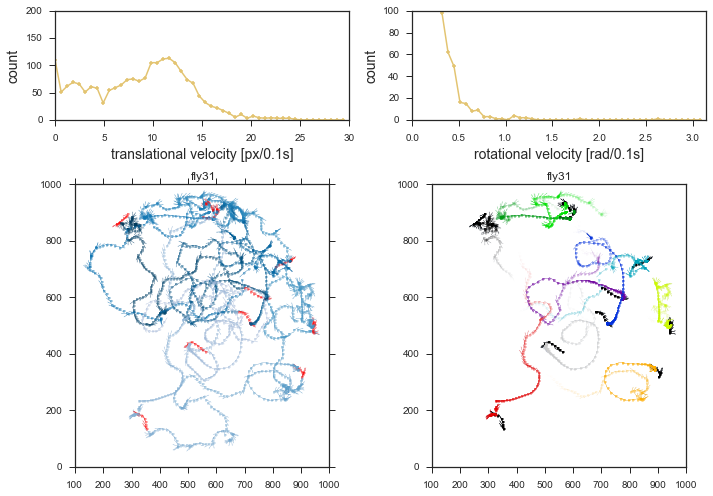

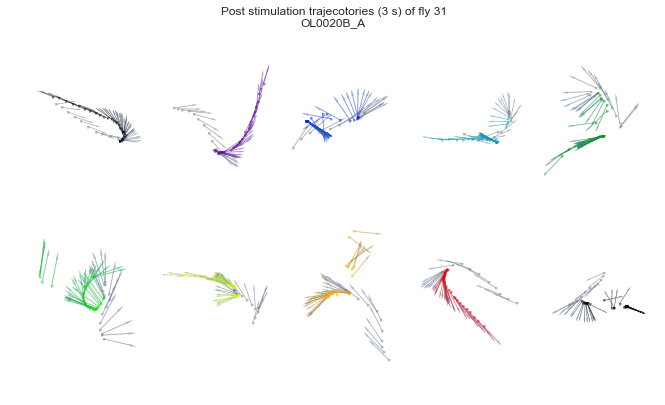

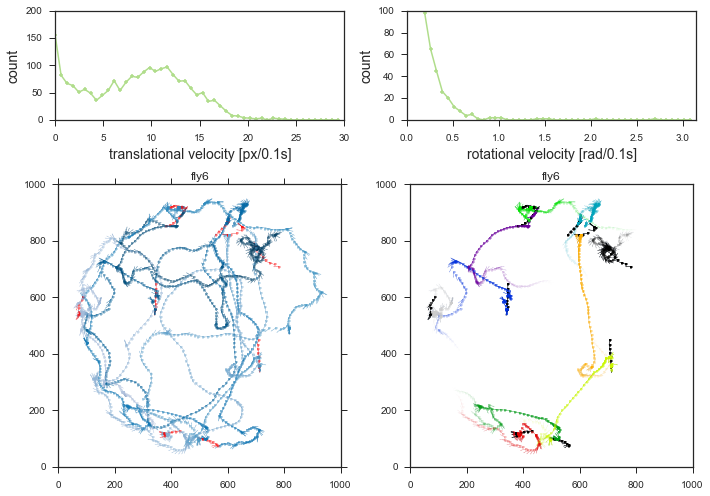

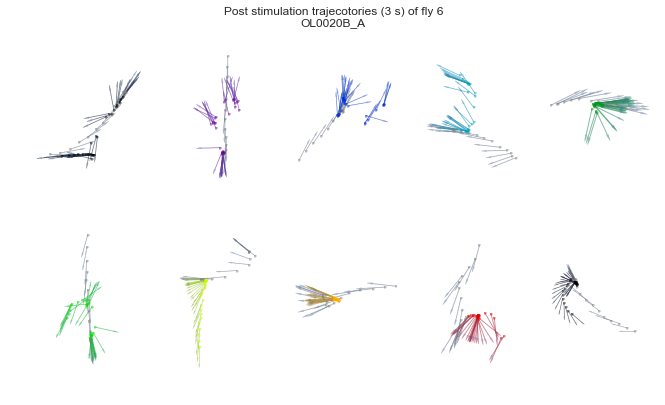

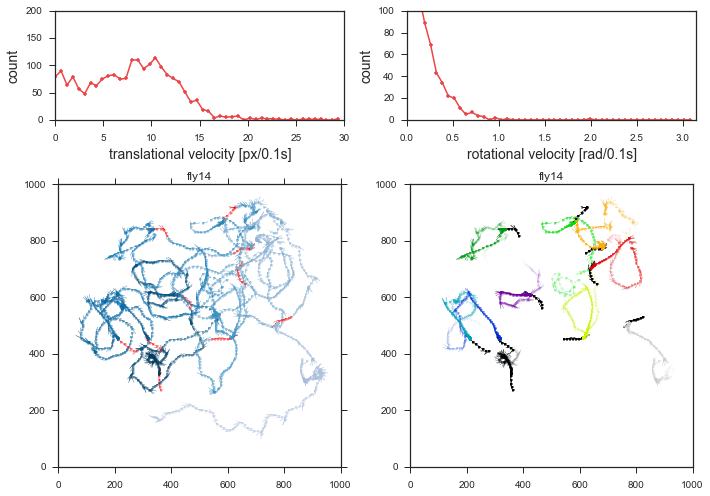

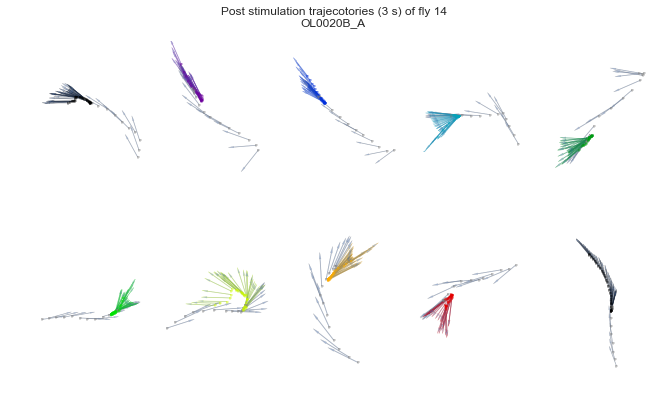

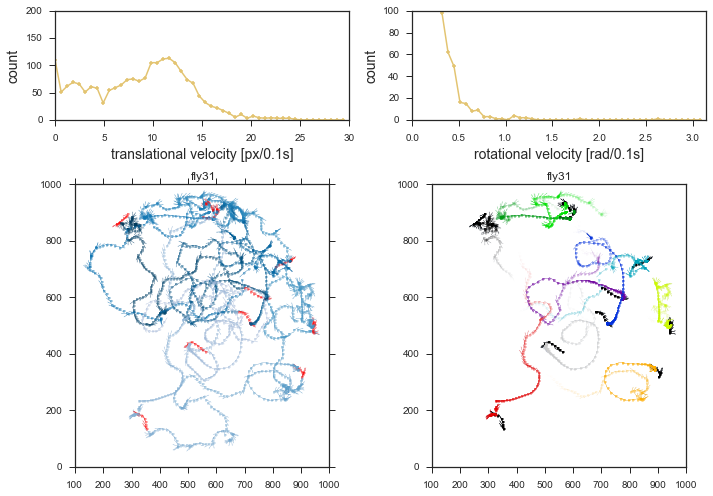

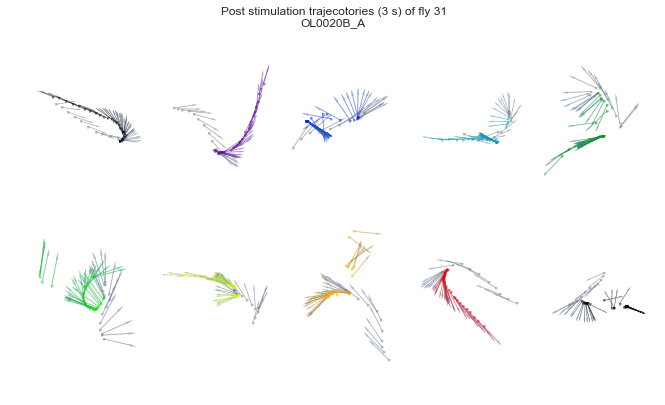

In [110]:
# Compute 'extreme flies' .........................................................................................
maxRotFly = np.nanargmax(abs(perFlyAvVR[:,1]),axis=0)
maxVFly = np.nanargmax(perFlyAvVT[:,1],axis=0)
minVFly = np.nanargmax(abs(perFlyAvVT[:,1]-perFlyAvVT[:,2]),axis=0)
maxTIFly = np.nanargmax(abs(perFlyAvTI[:,1]),axis=0)

# Run more detailed analysis on 'extreme flies'
def visualiseSingleFlyTraces(fly, flyName):
    skipFrame = 3
    fullExperiment = range(delayStart*fps,(delayStart + numRepeat*((stimTms+pauseTms)/1000)) * fps,skipFrame)
    stimCodeFrames = stimCode[range(0,len(stimCode),skipFrame)]
    trialCodeFrames = trialCode[range(0,len(trialCode),skipFrame)]

    fig=plt.figure(figsize=(10,7))

    tVplt = fig.add_subplot(3,2,1)
    plotVeloHistogram(transV,fly,np.linspace(0,30,50),tVplt,'translational velocity [px/0.1s]',FlyMap.to_rgba(fly))
    tVplt.set_ylim((0,200))
    tVplt.set_xlim((0,30))


    rVplt = fig.add_subplot(3,2,2)
    plotVeloHistogram(rotV,fly,np.linspace(0,np.pi,50),rVplt,'rotational velocity [px/0.1s]',FlyMap.to_rgba(fly))
    rVplt.set_ylim((0,100))
    rVplt.set_xlim((0,np.pi))
    rVplt.set_xlabel('rotational velocity [rad/0.1s]',fontsize = 14)


    posPlt = fig.add_subplot(3,2,(3,5))
    posPlt.set_title('fly' + str(fly))
    plotPosInRange_singleFly_colorStim(posPlt,fullExperiment,stimCodeFrames,xPos,yPos,angle,fly,'PuBu')


    posPlt = fig.add_subplot(3,2,(4,6))
    posPlt.set_title('fly' + str(fly))
    plotPosInRange_singleFly_colorTrial(posPlt,fullExperiment,stimCodeFrames,trialCodeFrames,
                                        len(trialCodeFrames)/numRepeat,xPos,yPos,angle,fly,'nipy_spectral')

    plt.tight_layout()
    fig.savefig(plotSaveDir+sep+genotype+'_'+experiment+'_'+flyName+'_fly'+str(fly)+'.pdf', format='pdf')

    trialBegin_traces = [(delayStart + k*(stimTms+pauseTms)/1000)*fps for k in range(numRepeat)]
    windowSize = stimTms/1000 + 2
    skipFrame = 2
    stimFrames = stimTms/1000 * fps
    postStimFrames = windowSize*fps

    currCmap = 'nipy_spectral'
    fig = plt.figure(figsize=(11,6))
    fig.suptitle('Post stimulation trajecotories (' + str(windowSize) + ' s) of fly ' + str(fly) + '\n' + genotype,  fontsize = 12)
    plotPosInRange_singleFly_separateTrials(fig,trialBegin_traces,numRepeat,stimFrames,postStimFrames,skipFrame,xPos,yPos,angle,fly,currCmap)

    fig.savefig(plotSaveDir+sep+genotype+'_'+experiment+ '_'+flyName+'_perTrialfly'+str(fly)+'.pdf', format='pdf')
    

visualiseSingleFlyTraces(maxRotFly, 'maxVRot')
visualiseSingleFlyTraces(maxVFly, 'maxVTrans')
visualiseSingleFlyTraces(minVFly, 'minVTrans')
visualiseSingleFlyTraces(maxTIFly, 'maxTurnInd')